# Precomputing of exisiting data

In [1]:
# precomputing before sharing symptoms
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
# model loading
def load_embedding_model(model_name="all-MiniLM-L6-v2"):
    return SentenceTransformer(model_name)
# loading of data and generate embeddings
def compute_embeddings(csv_path: str,
                       text_column: str,
                       limit: int = 600):

    # Clean accidental quotes in path
    csv_path = csv_path.strip().strip('"').strip("'")

    df = pd.read_csv(csv_path)

    if text_column not in df.columns:
        raise ValueError(f"Column '{text_column}' not found in dataset.")

    # Select first 600 subjects
    df_subset = df.head(limit)

    texts = df_subset[text_column].astype(str).tolist()

    print(f"\nGenerating embeddings for {len(texts)} subjects...\n")

    model = load_embedding_model()

    embeddings = model.encode(
        texts,
        convert_to_numpy=True,
        show_progress_bar=True
    )

    # IMPORTANT: Normalize embeddings for proper cosine similarity
    embeddings = normalize(embeddings, norm="l2")

    return df_subset, embeddings
# computing cosine similarity
def compute_similarity_matrix(embeddings: np.ndarray):
    similarity_matrix = cosine_similarity(embeddings)
    return similarity_matrix

# main execution
if __name__ == "__main__":

    # Get User Inputs 
    csv_path = input("Enter full path to preprocessed CSV file:\n>> ")
    text_column = input("Enter text column name (e.g., note_preprocessed):\n>> ")

    # Step 1: Generate Embeddings 
    patient_df, stored_embeddings = compute_embeddings(
        csv_path=csv_path,
        text_column=text_column,
        limit=600
    )

    print("\nEmbedding Matrix Shape:", stored_embeddings.shape)

    # ---- Step 2: Compute Cosine Similarity ----
    print("\nComputing cosine similarity matrix...\n")

    similarity_matrix = compute_similarity_matrix(stored_embeddings)

    print("Cosine Similarity Matrix Shape:", similarity_matrix.shape)

    print("\nProcess Completed Successfully.")

C:\Users\rajak\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Enter full path to preprocessed CSV file:
>>  C:\Users\rajak\Downloads\AI Internship\newdataset.csv
Enter text column name (e.g., note_preprocessed):
>>  note_preprocessed



Generating embeddings for 600 subjects...



Loading weights: 100%|█████████████████████| 103/103 [00:00<00:00, 306.17it/s, Materializing param=pooler.dense.weight]
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|█████████████████████████████████████████████████████████████████████████| 19/19 [00:31<00:00,  1.66s/it]


Embedding Matrix Shape: (600, 384)

Computing cosine similarity matrix...

Cosine Similarity Matrix Shape: (600, 600)

Process Completed Successfully.


completed the precomputing of the existing data for our end to end ccms stimulation

# End to end ccms stimulation

at first end to end ccms stimulation has been carried out for the first top three existing patients 

In [5]:
# end to end ccms outline
import re
import json
import numpy as np
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

# mentioning the keywords
TREATMENT_KEYWORDS = [
    "oxygen therapy","supplemental oxygen","high flow oxygen",
    "non invasive ventilation","mechanical ventilation",
    "remdesivir","dexamethasone","steroid therapy",
    "antibiotics","heparin","bronchodilator",
    "physiotherapy","pulmonary rehabilitation",
    "icu admission","critical care monitoring"
]

OUTCOME_KEYWORDS = {
    "discharged": ["discharged","home discharge"],
    "rehabilitation": ["rehabilitation","rehab clinic"],
    "critical_monitoring": ["icu","intensive care","critical"],
    "improved": ["improved","stable condition"]
}

# similar case function
def retrieve_similar_cases(new_embedding, top_n=4):

    global stored_embeddings

    if new_embedding.ndim == 1:
        new_embedding = new_embedding.reshape(1, -1)

    similarity_scores = cosine_similarity(
        new_embedding,
        stored_embeddings
    )[0]

    # Remove self match
    self_index = np.argmax(similarity_scores)
    similarity_scores[self_index] = -1

    ranked_indices = np.argsort(similarity_scores)[::-1]

    top_indices = ranked_indices[:top_n]
    top_scores = similarity_scores[top_indices]

    return top_indices, top_scores


# insight pipeline
def endtoend_CCMS(patient_index):

    query_embedding = stored_embeddings[patient_index]

    # 🔹 Changed here → top_n=4
    top_indices, top_scores = retrieve_similar_cases(
        new_embedding=query_embedding,
        top_n=4
    )

    similar_texts = patient_df.iloc[top_indices]["note_preprocessed"].tolist()

    # Treatment Pattern 
    treatment_counter = Counter()
    for text in similar_texts:
        for treatment in TREATMENT_KEYWORDS:
            if treatment in text:
                treatment_counter.update([treatment])

    common_treatments = [t for t, _ in treatment_counter.most_common(3)]

    # Outcome Pattern 
    outcome_counter = Counter()
    for text in similar_texts:
        for outcome, keywords in OUTCOME_KEYWORDS.items():
            if any(k in text for k in keywords):
                outcome_counter.update([outcome])

    outcome_pattern = "Not clearly observed"
    if outcome_counter:
        outcome_pattern = outcome_counter.most_common(1)[0][0]

    # Confidence Score
    high_similarity_cases = sum(score > 0.75 for score in top_scores)
    confidence_score = round(float(np.mean(top_scores)), 4)

    confidence_statement = (
        f"Based on {high_similarity_cases} highly similar historical cases, "
        f"the confidence score obtained is {confidence_score}."
    )

    # Structured Output 
    result = {
        "query_patient_id": patient_df.iloc[patient_index]["patient_uid"]
        if "patient_uid" in patient_df.columns else int(patient_index),

        "similar_cases": [
            {
                "patient_id": patient_df.iloc[idx]["patient_uid"]
                if "patient_uid" in patient_df.columns else int(idx),
                "similarity_score": round(float(score), 4)
            }
            for idx, score in zip(top_indices, top_scores)
        ],

        "common_treatment_pattern": common_treatments,
        "outcome_pattern": outcome_pattern,
        "confidence_reason": confidence_statement
    }

    return result


# main execution
if __name__ == "__main__":

    print("\nGenerating insights for First 3 Subjects\n")

    for patient_index in range(3):

        output = endtoend_CCMS(patient_index)

        print(f"\n===== Patient Index {patient_index} =====\n")
        print(json.dumps(output, indent=4))


Generating insights for First 3 Subjects


===== Patient Index 0 =====

{
    "query_patient_id": 0,
    "similar_cases": [
        {
            "patient_id": 1,
            "similarity_score": 0.854
        },
        {
            "patient_id": 6,
            "similarity_score": 0.8378
        },
        {
            "patient_id": 4,
            "similarity_score": 0.8367
        },
        {
            "patient_id": 2,
            "similarity_score": 0.8082
        }
    ],
    "common_treatment_pattern": [
        "supplemental oxygen",
        "oxygen therapy",
        "icu admission"
    ],
    "outcome_pattern": "discharged",
    "confidence_reason": "Based on 4 highly similar historical cases, the confidence score obtained is 0.8342."
}

===== Patient Index 1 =====

{
    "query_patient_id": 1,
    "similar_cases": [
        {
            "patient_id": 6,
            "similarity_score": 0.8898
        },
        {
            "patient_id": 0,
            "similarity_score":

created the end to end ccms pipeline. That provides the provides the confidece reason based on 4 highly similar patient for the common treatment and outcome pattern.

# Testing with input samples

 testing the end to end ccms pipeline with the sample input

In [8]:
# end to end ccms pipeline
import re
import json
import numpy as np
from collections import Counter
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.preprocessing import normalize
# defining the keyword
TREATMENT_KEYWORDS = [
    "oxygen therapy","supplemental oxygen","high flow oxygen",
    "non invasive ventilation","mechanical ventilation",
    "remdesivir","dexamethasone","steroid therapy",
    "antibiotics","heparin","bronchodilator",
    "physiotherapy","pulmonary rehabilitation",
    "icu admission","critical care monitoring"
]
#preprocessing of data
IMPORTANT_WORDS = {"no","not","without","with","before","after","during","since"}
CUSTOM_STOPWORDS = ENGLISH_STOP_WORDS.difference(IMPORTANT_WORDS)

def preprocess_text(text):

    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    words = text.split()
    words = [w for w in words if w not in CUSTOM_STOPWORDS]

    return " ".join(words)
# loading of embedding model
def load_embedding_model():
    return SentenceTransformer("all-MiniLM-L6-v2")
# finding the similar patient cases
def retrieve_similar_cases(new_embedding, top_n=4):

    global stored_embeddings

    if new_embedding.ndim == 1:
        new_embedding = new_embedding.reshape(1, -1)

    new_embedding = normalize(new_embedding, norm="l2")

    similarity_scores = cosine_similarity(
        new_embedding,
        stored_embeddings
    )[0]

    ranked_indices = np.argsort(similarity_scores)[::-1]

    top_indices = ranked_indices[:top_n]
    top_scores = similarity_scores[top_indices]

    return top_indices, top_scores
# end to end ccms pipelin
def run_user_CCMS(symptoms, notes):

    global patient_df

    #  Combine & Preprocess 
    combined_text = preprocess_text(symptoms + " " + notes)

    #  Generate Embedding 
    model = load_embedding_model()

    query_embedding = model.encode(
        [combined_text],
        convert_to_numpy=True
    )[0]

    # Retrieve Similar Cases 
    top_indices, top_scores = retrieve_similar_cases(
        new_embedding=query_embedding,
        top_n=4
    )

    similar_texts = patient_df.iloc[top_indices]["note_preprocessed"].tolist()

    # Treatment Pattern Extraction 
    treatment_counter = Counter()
    for text in similar_texts:
        for treatment in TREATMENT_KEYWORDS:
            if treatment in text:
                treatment_counter.update([treatment])

    common_treatments = [t for t, _ in treatment_counter.most_common(3)]

    # Confidence Score 
    confidence_score = round(float(np.mean(top_scores)), 4)
    high_similarity_cases = sum(score > 0.5 for score in top_scores)
    confidence_statement = (
        f"Based on {high_similarity_cases} highly similar historical cases, "
        f"the confidence score obtained is {confidence_score}." )

    #  Structured Output 
    result = {
        "similar_cases": [
            {
                "patient_id": patient_df.iloc[idx]["patient_uid"]
                if "patient_uid" in patient_df.columns else int(idx),
                "similarity_score": round(float(score), 4)
            }
            for idx, score in zip(top_indices, top_scores)
        ],
        "common_treatment_pattern": common_treatments,
        "confidence_score": confidence_statement
    }

    return result
# main execution
if __name__ == "__main__":

    symptoms_input = input("Enter patient symptoms:\n>> ")
    notes_input = input("\nEnter clinical notes:\n>> ")

    output = run_user_CCMS(symptoms_input, notes_input)

    print("\nFinal Output (JSON Format):\n")
    print(json.dumps(output, indent=4))

Enter patient symptoms:
>>  fever, dry cough, shortness of breath

Enter clinical notes:
>>  Patient admitted with four day history of fever and persistent dry cough associated with progressive shortness of breath. Oxygen saturation mildly reduced requiring supplemental oxygen therapy. No prior chronic respiratory illness reported.


Loading weights: 100%|█████████████████████| 103/103 [00:00<00:00, 527.35it/s, Materializing param=pooler.dense.weight]
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Final Output (JSON Format):

{
    "similar_cases": [
        {
            "patient_id": 60,
            "similarity_score": 0.6396
        },
        {
            "patient_id": 59,
            "similarity_score": 0.598
        },
        {
            "patient_id": 9,
            "similarity_score": 0.572
        },
        {
            "patient_id": 192,
            "similarity_score": 0.5636
        }
    ],
    "common_treatment_pattern": [
        "oxygen therapy",
        "high flow oxygen",
        "remdesivir"
    ],
    "confidence_score": "Based on 4 highly similar historical cases, the confidence score obtained is 0.5933."
}


Tested the developed end to end ccms pipeline with the sample input 1. From the input provided it finds the confidence score of 0.59 from the top 4 similar cases.

Testing the end to end ccms pipeline with the input sample 2

In [9]:
# end to end ccms pipeline
import re
import json
import numpy as np
from collections import Counter
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.preprocessing import normalize
# defining the keyword
TREATMENT_KEYWORDS = [
    "oxygen therapy","supplemental oxygen","high flow oxygen",
    "non invasive ventilation","mechanical ventilation",
    "remdesivir","dexamethasone","steroid therapy",
    "antibiotics","heparin","bronchodilator",
    "physiotherapy","pulmonary rehabilitation",
    "icu admission","critical care monitoring"
]
#preprocessing of data
IMPORTANT_WORDS = {"no","not","without","with","before","after","during","since"}
CUSTOM_STOPWORDS = ENGLISH_STOP_WORDS.difference(IMPORTANT_WORDS)

def preprocess_text(text):

    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    words = text.split()
    words = [w for w in words if w not in CUSTOM_STOPWORDS]

    return " ".join(words)
# loading of embedding model
def load_embedding_model():
    return SentenceTransformer("all-MiniLM-L6-v2")
# finding the similar patient cases
def retrieve_similar_cases(new_embedding, top_n=4):

    global stored_embeddings

    if new_embedding.ndim == 1:
        new_embedding = new_embedding.reshape(1, -1)

    new_embedding = normalize(new_embedding, norm="l2")

    similarity_scores = cosine_similarity(
        new_embedding,
        stored_embeddings
    )[0]

    ranked_indices = np.argsort(similarity_scores)[::-1]

    top_indices = ranked_indices[:top_n]
    top_scores = similarity_scores[top_indices]

    return top_indices, top_scores
# end to end ccms pipelin
def run_user_CCMS(symptoms, notes):

    global patient_df

    #  Combine & Preprocess 
    combined_text = preprocess_text(symptoms + " " + notes)

    #  Generate Embedding 
    model = load_embedding_model()

    query_embedding = model.encode(
        [combined_text],
        convert_to_numpy=True
    )[0]

    # Retrieve Similar Cases 
    top_indices, top_scores = retrieve_similar_cases(
        new_embedding=query_embedding,
        top_n=4
    )

    similar_texts = patient_df.iloc[top_indices]["note_preprocessed"].tolist()

    # Treatment Pattern Extraction 
    treatment_counter = Counter()
    for text in similar_texts:
        for treatment in TREATMENT_KEYWORDS:
            if treatment in text:
                treatment_counter.update([treatment])

    common_treatments = [t for t, _ in treatment_counter.most_common(3)]

    # Confidence Score 
    confidence_score = round(float(np.mean(top_scores)), 4)
    high_similarity_cases = sum(score > 0.5 for score in top_scores)
    confidence_statement = (
        f"Based on {high_similarity_cases} highly similar historical cases, "
        f"the confidence score obtained is {confidence_score}." )

    #  Structured Output 
    result = {
        "similar_cases": [
            {
                "patient_id": patient_df.iloc[idx]["patient_uid"]
                if "patient_uid" in patient_df.columns else int(idx),
                "similarity_score": round(float(score), 4)
            }
            for idx, score in zip(top_indices, top_scores)
        ],
        "common_treatment_pattern": common_treatments,
        "confidence_score": confidence_statement
    }

    return result
# main execution
if __name__ == "__main__":

    symptoms_input = input("Enter patient symptoms:\n>> ")
    notes_input = input("\nEnter clinical notes:\n>> ")

    output = run_user_CCMS(symptoms_input, notes_input)

    print("\nFinal Output (JSON Format):\n")
    print(json.dumps(output, indent=4))

Enter patient symptoms:
>>  oxygen desaturation, dyspnea, fatigue

Enter clinical notes:
>>  Elderly male presented with worsening dyspnea and oxygen desaturation over the past two days. Patient required high flow oxygen support and close monitoring in intensive care unit. Fatigue and respiratory distress observed during minimal exertion.


Loading weights: 100%|█████████████████████| 103/103 [00:00<00:00, 332.02it/s, Materializing param=pooler.dense.weight]
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Final Output (JSON Format):

{
    "similar_cases": [
        {
            "patient_id": 9,
            "similarity_score": 0.6081
        },
        {
            "patient_id": 8,
            "similarity_score": 0.5709
        },
        {
            "patient_id": 6,
            "similarity_score": 0.5533
        },
        {
            "patient_id": 2,
            "similarity_score": 0.5462
        }
    ],
    "common_treatment_pattern": [
        "oxygen therapy",
        "icu admission"
    ],
    "confidence_score": "Based on 4 highly similar historical cases, the confidence score obtained is 0.5696."
}


Tested the developed end to end ccms pipeline with the sample input two. the output shows that confidence score of 0.57 for the provided user input based on top 4 highly similar cases.

Testing the end to end CCMS pipeline with the sample input 3

In [10]:
# end to end ccms pipeline
import re
import json
import numpy as np
from collections import Counter
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.preprocessing import normalize
# defining the keyword
TREATMENT_KEYWORDS = [
    "oxygen therapy","supplemental oxygen","high flow oxygen",
    "non invasive ventilation","mechanical ventilation",
    "remdesivir","dexamethasone","steroid therapy",
    "antibiotics","heparin","bronchodilator",
    "physiotherapy","pulmonary rehabilitation",
    "icu admission","critical care monitoring"
]
#preprocessing of data
IMPORTANT_WORDS = {"no","not","without","with","before","after","during","since"}
CUSTOM_STOPWORDS = ENGLISH_STOP_WORDS.difference(IMPORTANT_WORDS)

def preprocess_text(text):

    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    words = text.split()
    words = [w for w in words if w not in CUSTOM_STOPWORDS]

    return " ".join(words)
# loading of embedding model
def load_embedding_model():
    return SentenceTransformer("all-MiniLM-L6-v2")
# finding the similar patient cases
def retrieve_similar_cases(new_embedding, top_n=4):

    global stored_embeddings

    if new_embedding.ndim == 1:
        new_embedding = new_embedding.reshape(1, -1)

    new_embedding = normalize(new_embedding, norm="l2")

    similarity_scores = cosine_similarity(
        new_embedding,
        stored_embeddings
    )[0]

    ranked_indices = np.argsort(similarity_scores)[::-1]

    top_indices = ranked_indices[:top_n]
    top_scores = similarity_scores[top_indices]

    return top_indices, top_scores
# end to end ccms pipelin
def run_user_CCMS(symptoms, notes):

    global patient_df

    #  Combine & Preprocess 
    combined_text = preprocess_text(symptoms + " " + notes)

    #  Generate Embedding 
    model = load_embedding_model()

    query_embedding = model.encode(
        [combined_text],
        convert_to_numpy=True
    )[0]

    # Retrieve Similar Cases 
    top_indices, top_scores = retrieve_similar_cases(
        new_embedding=query_embedding,
        top_n=4
    )

    similar_texts = patient_df.iloc[top_indices]["note_preprocessed"].tolist()

    # Treatment Pattern Extraction 
    treatment_counter = Counter()
    for text in similar_texts:
        for treatment in TREATMENT_KEYWORDS:
            if treatment in text:
                treatment_counter.update([treatment])

    common_treatments = [t for t, _ in treatment_counter.most_common(3)]

    # Confidence Score 
    confidence_score = round(float(np.mean(top_scores)), 4)
    high_similarity_cases = sum(score > 0.5 for score in top_scores)
    confidence_statement = (
        f"Based on {high_similarity_cases} highly similar historical cases, "
        f"the confidence score obtained is {confidence_score}." )

    #  Structured Output 
    result = {
        "similar_cases": [
            {
                "patient_id": patient_df.iloc[idx]["patient_uid"]
                if "patient_uid" in patient_df.columns else int(idx),
                "similarity_score": round(float(score), 4)
            }
            for idx, score in zip(top_indices, top_scores)
        ],
        "common_treatment_pattern": common_treatments,
        "confidence_score": confidence_statement
    }

    return result
# main execution
if __name__ == "__main__":

    symptoms_input = input("Enter patient symptoms:\n>> ")
    notes_input = input("\nEnter clinical notes:\n>> ")

    output = run_user_CCMS(symptoms_input, notes_input)

    print("\nFinal Output (JSON Format):\n")
    print(json.dumps(output, indent=4))

Enter patient symptoms:
>>  fever, headache, loss of smell

Enter clinical notes:
>>  Patient reported low grade fever with persistent headache and recent loss of smell. Respiratory status stable without need for mechanical ventilation. Managed conservatively with monitoring and supportive care.


Loading weights: 100%|█████████████████████| 103/103 [00:00<00:00, 562.41it/s, Materializing param=pooler.dense.weight]
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Final Output (JSON Format):

{
    "similar_cases": [
        {
            "patient_id": 188,
            "similarity_score": 0.5236
        },
        {
            "patient_id": 7,
            "similarity_score": 0.5226
        },
        {
            "patient_id": 186,
            "similarity_score": 0.495
        },
        {
            "patient_id": 425,
            "similarity_score": 0.4843
        }
    ],
    "common_treatment_pattern": [
        "mechanical ventilation",
        "icu admission"
    ],
    "confidence_score": "Based on 2 highly similar historical cases, the confidence score obtained is 0.5064."
}


Tested the developed end to end ccms pipeline with the sample input three. the output shows that confidence score of 0.50 (very less confidence value) for the provided user input based on top 4 highly similar cases. This very lesser confidence value is due to lesser overlap of the clinical notes and symptoms with the existing ones.

# pipeline explanation

Architecture of the developed model

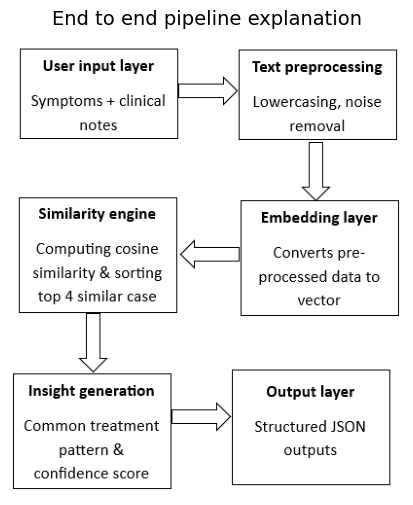

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load image
img = mpimg.imread(r"C:\Users\rajak\OneDrive\Pictures\Screenshots\Screenshot 2026-02-23 140032.png")

# Display image
plt.figure(figsize=(8,6))
plt.imshow(img)
plt.title("End to end pipeline explanation", fontsize=14)
plt.axis("off")
plt.show()


Pipeline explanation

The developed pipeline accepts the symptoms and unstructured clinical notes from the user, which are combined into a unified clinical description.
The combined input undergoes lowercasing, noise removal, and stop word handling to preserve meaningful terms while removing irrelevant noise.
Then, the processed text is converted into a dense numerical vector, which enables the semantic representation of the clinical information.
The generated embedding is compared against precomputed existing embedding using cosine similarity, and the top 4 similar cases are selected based on the similarity scores.
The system analyzes the sorted similar cases to identify frequently occurring treatments, which determines the common treatment among highly similar patients.
A confidence score is then computed to show the significance of the suggested treatment.
Final structured JSON output presents similar cases with the similarity score, treatment pattern, and confidence score in a clear and interpretable format.